### Setup

In [8]:
# installing
!pip install datasets

#!pip install transformers
#!pip install hydra-core
#!pip install fairseq

     |████████████████████████████████| 194kB 4.2MB/s 
     |████████████████████████████████| 112kB 5.1MB/s 
     |████████████████████████████████| 245kB 7.0MB/s 


In [9]:
# load packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data import random_split

import torch.nn as nn
import torch.nn.functional as F

import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords

In [4]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data

In [ ]:
# pre-processing (frequency filtering necessary?)
# data loader (any augmentation techniques in NLP?)
# https://www.machinecurve.com/index.php/2021/02/17/easy-speech-recognition-with-machine-learning-and-huggingface-transformers/

In [10]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/data/ASR_train.csv')

FileNotFoundError: ignored

In [5]:
# load one recording
# audio processing: https://librosa.org/doc/main/generated/librosa.load.html
import librosa as lb
waveform, rate = lb.load('drive/MyDrive/Colab Notebooks/data/clips/002d664d839e581e4f0b69376f9187d924f082606576eaeac79c80597fe0461595f254686aafac98f6092b2b259452ae9ae793b037d3b1ce951a6b754fe3e009.mp3', sr = 16000)

print(waveform)
print(waveform.shape)
print(max(waveform))
print(min(waveform))

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


[ 0.          0.          0.         ... -0.00010767 -0.0003888
 -0.00011762]
(35328,)
0.037488017
-0.043132786


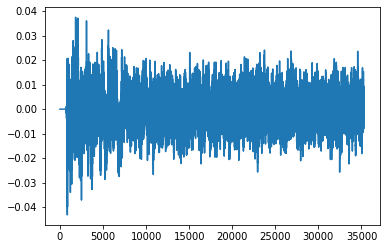

In [6]:
# plot waveform
plt.figure()
plt.plot(waveform)
plt.show()

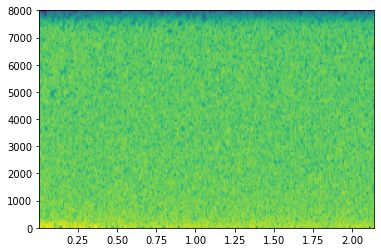

In [ ]:
# plot power spectrum density
plt.figure()
plt.specgram(waveform[1000:], Fs=16000, mode='psd', scale='dB')
plt.show()

### Model

In [3]:
# model (CNN + BERT? Bi-LSTM?)

#### Wav2vec2

In [ ]:
# model (CNN + BERT? Bi-LSTM?)
from transformers import Wav2Vec2Tokenizer, Wav2Vec2ForCTC # https://huggingface.co/facebook/wav2vec2-large-960h
from datasets import load_dataset # https://github.com/huggingface/datasets
import soundfile as sf
import torch

# load model and tokenizer
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")
# model = Wav2Vec2ForMaskedLM.from_pretrained("facebook/wav2vec2-base-960h")

#print(model.parameters)

# define function to read in sound file
def map_to_array(batch):
    speech, _ = sf.read(batch["file"])
    batch["speech"] = speech
    return batch

# load dummy dataset and read soundfiles
ds = load_dataset("patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")
ds = ds.map(map_to_array)

# tokenize
input_values = tokenizer(ds["speech"][:2], return_tensors="pt", padding="longest").input_values  # Batch size 1

# retrieve logits
logits = model(input_values).logits

# take argmax and decode
predicted_ids = torch.argmax(logits, dim=-1)
transcription = tokenizer.batch_decode(predicted_ids)

Reusing dataset librispeech_asr (/root/.cache/huggingface/datasets/librispeech_asr/clean/2.1.0/468ec03677f46a8714ac6b5b64dba02d246a228d92cbbad7f3dc190fa039eab1)
Loading cached processed dataset at /root/.cache/huggingface/datasets/librispeech_asr/clean/2.1.0/468ec03677f46a8714ac6b5b64dba02d246a228d92cbbad7f3dc190fa039eab1/cache-99e95014b26a2688.arrow


In [ ]:
print(len(waveform))
print(len(ds["speech"][0]))

input_values = tokenizer(waveform, return_tensors="pt").input_values
print(input_values[:5])


# retrieve logits
logits = model(input_values).logits
print(logits[:5])

# take argmax and decode
predicted_ids = torch.argmax(logits, dim=-1)
print(predicted_ids[:5])


transcription = tokenizer.batch_decode(predicted_ids)

print(transcription)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

for p in model.parameters():
           p.requires_grad = False

print(count_parameters(model))

315460768
0


#### XLSR Model

In [1]:
# install directly from Github. installing it from pip leads to dependency issues
%cd "/content/drive/My Drive/Colab Notebooks/"
!git clone https://github.com/pytorch/fairseq
%cd fairseq
!pip install --editable .

[Errno 2] No such file or directory: '/content/drive/My Drive/Colab Notebooks/'
/content
Cloning into 'fairseq'...
remote: Enumerating objects: 21756, done.
remote: Total 21756 (delta 0), reused 0 (delta 0), pack-reused 21756
Receiving objects: 100% (21756/21756), 10.03 MiB | 25.12 MiB/s, done.
Resolving deltas: 100% (16242/16242), done.
/content/fairseq
Obtaining file:///content/fairseq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 61kB 3.0MB/s 
     |████████████████████████████████| 133kB 5.8MB/s 
     |████████████████████████████████| 112kB 5.4MB/s 
     |████████████████████████████████| 645kB 7.1MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-cp37-none-any.whl size=141231 sha256=2e1b236328b709034e30b1a694b25e52853542e8b25f9d7e0e7424585e683ab9
  Stored in directory: /root/.cache/pip

In [5]:
# load model
#import fairseq
model, cfg, task  = fairseq.checkpoint_utils.load_model_ensemble_and_task(
    ["../drive/My Drive/Colab Notebooks/model/xlsr_53_56k.pt"])
#/content/drive/My Drive/Colab Notebooks

In [6]:
# evaluation mode
model = model[0] # not sure why this is needed
model.eval()

Wav2Vec2Model(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
        (1): Dropout(p=0.0, inplace=False)
        (2): Sequential(
          (0): TransposeLast()
          (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (2): TransposeLast()
        )
        (3): GELU()
      )
      (1): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
        (1): Dropout(p=0.0, inplace=False)
        (2): Sequential(
          (0): TransposeLast()
          (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (2): TransposeLast()
        )
        (3): GELU()
      )
      (2): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
        (1): Dropout(p=0.0, inplace=False)
        (2): Sequential(
          (0): TransposeLast()
          (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True

In [11]:
# https://colab.research.google.com/drive/1ljU1AfzMQkcMsS2VdR3AIMMHD5NwFhHV?usp=sharing#scrollTo=loFnGT4v4kxf
import torch
from datasets import load_dataset
import soundfile as sf
from itertools import groupby

libri_dummy = load_dataset(
    "patrickvonplaten/librispeech_asr_dummy", "clean", split="validation")


def map_to_array(batch):
    speech_array, _ = sf.read(batch["file"])
    batch["speech"] = speech_array
    return batch


class Decoder:
    def __init__(self, json_dict):
        self.dict = json_dict
        self.look_up = np.asarray(list(self.dict.keys()))

    def decode(self, ids):
        converted_tokens = self.look_up[ids]
        fused_tokens = [tok[0] for tok in groupby(converted_tokens)]
        output = ' '.join(
            ''.join(''.join(fused_tokens).split("<s>")).split("|"))
        return output


libri_dummy = libri_dummy.map(map_to_array, remove_columns=["file"])


input_sample = torch.tensor(libri_dummy[0]["speech"])[None, :]

logits = model(source=input_sample, padding_mask=None)["encoder_out"]
#logits = model(source=input_sample)["cpc_logits"]
# print(logits)

predicted_ids = torch.argmax(logits[:, 0], axis=-1)
json_dict = {"<s>": 0, "<pad>": 1, "</s>": 2, "<unk>": 3, "|": 4, "E": 5, "T": 6, "A": 7, "O": 8, "N": 9, "I": 10, "H": 11, "S": 12, "R": 13, "D": 14,
             "L": 15, "U": 16, "M": 17, "W": 18, "C": 19, "F": 20, "G": 21, "Y": 22, "P": 23, "B": 24, "V": 25, "K": 26, "'": 27, "X": 28, "J": 29, "Q": 30, "Z": 31}

decoder = Decoder(json_dict=json_dict)
print("Prediction: ", decoder.decode(predicted_ids))

Dataset librispeech_asr downloaded and prepared to /root/.cache/huggingface/datasets/librispeech_asr/clean/2.1.0/468ec03677f46a8714ac6b5b64dba02d246a228d92cbbad7f3dc190fa039eab1. Subsequent calls will reuse this data.


KeyError: ignored

In [19]:
print(transcription)

tensor([ 10, 118, 106, 116, 106, 106, 139, 101, 134, 100,  35, 108, 108,  37,
        139,  96, 111, 109,  29, 108, 109,  34, 138, 138, 138, 104,   4, 107,
         15, 145,  35, 107, 132, 141,  75, 139,   9,  96, 132, 121,  24,  96,
         74, 114,  97, 108, 108, 132, 145, 138,  97,  39, 119,   5,  97,  37,
         75, 117,   6,  37, 140,  35,  15, 139,   8, 116, 119,  15, 139,   5,
         75, 145, 109, 108,  41,  23,  75, 139, 107,   4, 139,  34,   4, 138,
          5, 111,  42, 101,  97,  29,  34,  29, 132, 138, 108,  16, 139,  14,
         43, 116,  42])


IndexError: ignored

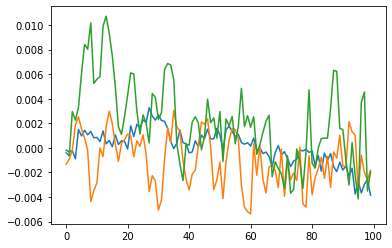

In [ ]:

plt.figure()
plt.plot(ds["speech"][0][:100])
plt.plot(ds["speech"][1][:100])
plt.plot(ds["speech"][2][:100])
plt.show()

In [ ]:
print(ds.format)
print(ds["file"])
print(transcription)

{'type': None, 'format_kwargs': {}, 'columns': ['chapter_id', 'file', 'id', 'speaker_id', 'speech', 'text'], 'output_all_columns': False}
['/root/.cache/huggingface/datasets/downloads/extracted/dfbece23564f422bc5794f3090902cd16d52d86767b746125ebc2ff3ea5f89ef/dev_clean/1272/135031/1272-135031-0000.flac', '/root/.cache/huggingface/datasets/downloads/extracted/dfbece23564f422bc5794f3090902cd16d52d86767b746125ebc2ff3ea5f89ef/dev_clean/1272/135031/1272-135031-0001.flac', '/root/.cache/huggingface/datasets/downloads/extracted/dfbece23564f422bc5794f3090902cd16d52d86767b746125ebc2ff3ea5f89ef/dev_clean/1272/135031/1272-135031-0002.flac', '/root/.cache/huggingface/datasets/downloads/extracted/dfbece23564f422bc5794f3090902cd16d52d86767b746125ebc2ff3ea5f89ef/dev_clean/1272/135031/1272-135031-0003.flac', '/root/.cache/huggingface/datasets/downloads/extracted/dfbece23564f422bc5794f3090902cd16d52d86767b746125ebc2ff3ea5f89ef/dev_clean/1272/135031/1272-135031-0004.flac', '/root/.cache/huggingface/datas

### Training

In [ ]:
# helper functions
# loss
# metric

In [ ]:
# train (fine-tuning)

In [ ]:
# validation

In [ ]:
# process

In [ ]:
# prediction